# Comparing CDR3 sequences of different species

This notebook used the VDJdb dataset to identify the possible usage of non-human CDR3 TCR sequences as OOD
dataset for predictors trained on human CDR3s.

## Load data

In [1]:
import pandas as pd
import os

datadir = '/Users/nle87788/PycharmProjects/tcr/data'
vdjdb_df = pd.read_csv(os.path.join(datadir, 'vdjdb/vdjdb-2021-09-05/vdjdb.txt'), sep='\t')

## Plots of CDR3 lengths

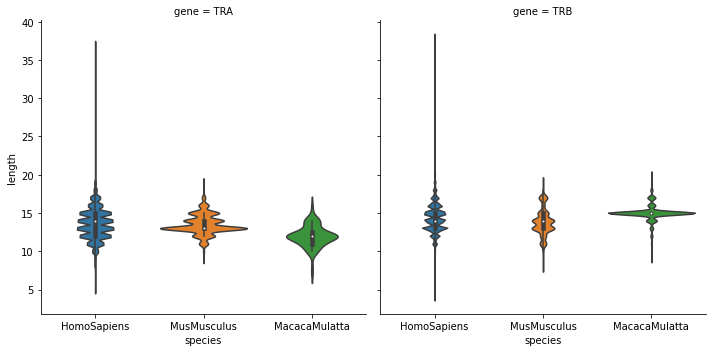

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

vdjdb_df['length'] = vdjdb_df.cdr3.apply(lambda x: len(x))
sns.catplot(data=vdjdb_df, y='length', x='species', col='gene', kind='violin')
plt.show()

## Plots of CDR3 amino acid compositions

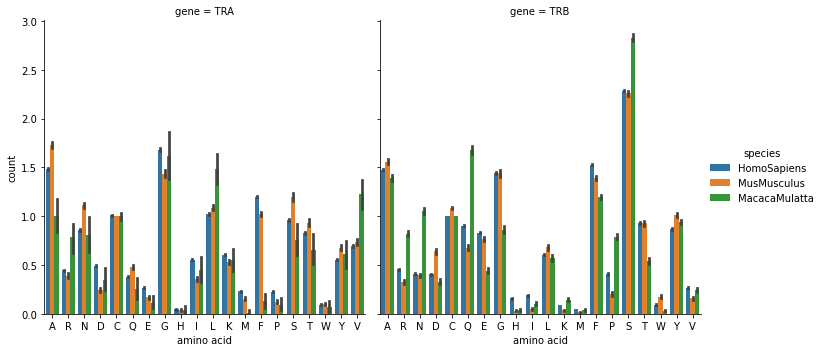

In [3]:
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
for aa in amino_acids:
    vdjdb_df[aa] = vdjdb_df.cdr3.apply(lambda x: x.count(aa))
aa_df = vdjdb_df.melt(id_vars=['gene', 'species'], value_vars=amino_acids, var_name='amino acid', value_name='count')
sns.catplot(data=aa_df, y='count', x='amino acid', hue='species', col='gene', kind='bar')
plt.show()

## Plot of epitope amino acid compositions

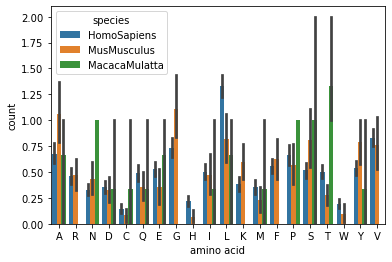

In [5]:
epitope_uq_df = vdjdb_df.drop_duplicates(subset=['antigen.epitope', 'species']).reset_index(drop=True)
for aa in amino_acids:
    epitope_uq_df[aa] = epitope_uq_df['antigen.epitope'].apply(lambda x: x.count(aa))
aa_df = epitope_uq_df.melt(id_vars=['antigen.epitope', 'species'],
                           value_vars=amino_acids, var_name='amino acid', value_name='count')
sns.barplot(data=aa_df, y='count', x='amino acid', hue='species')
plt.show()

## Simple RF classifier for predicting species from CDR3 sequence
### Data preprocessing

In [6]:
from sklearn.model_selection import train_test_split

# Onehot encoding
enc_dict = {x : list() for x in amino_acids}
for i, x in enumerate(amino_acids):
   enc_dict[x] = [0] * len(amino_acids)
   enc_dict[x][i] = 1
enc_dict['x'] = [0] * len(amino_acids)
# Pad
maxlen = vdjdb_df.cdr3.map(len).max()
vdjdb_df['cdr3'] = vdjdb_df.cdr3.apply(lambda x: ''.join([x, 'x' * (maxlen - len(x))]))
# Encode
vdjdb_df['cdr3_enc'] = vdjdb_df.cdr3.apply(lambda x: [enc_dict[y] for y in list(x)])
# Flatten
vdjdb_df['cdr3_enc'] = vdjdb_df.cdr3_enc.apply(lambda x: [y for l in x for y in l])

### Training models for alpha and beta (mouse and human)

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Keep human and mouse only
vdjdb_df = vdjdb_df[(vdjdb_df.species == 'HomoSapiens') | (vdjdb_df.species == 'MusMusculus')]
vdjdb_df['species'] = vdjdb_df.species.apply(lambda x: 1 if x == 'HomoSapiens' else 0)
tra_df = vdjdb_df.loc[vdjdb_df.gene == 'TRA']
# Randomly select as many human TCRs as there are mouse TCRs to avoid class imbalance
tra_hs_df = tra_df.loc[tra_df['species'] == 1].sample(
    n=len(tra_df.loc[tra_df['species'] == 0]), replace=False, random_state=1
)
tra_mm_df = tra_df.loc[tra_df['species'] == 0]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    tra_hs_df['cdr3_enc'].to_list() + tra_mm_df['cdr3_enc'].to_list(),
    tra_hs_df['species'].to_list() + tra_mm_df['species'].to_list(),
    test_size=0.2,
    random_state=0)
clf_alpha = RandomForestClassifier().fit(X_train_a, y_train_a)

# Do the same for beta
trb_df = vdjdb_df.loc[vdjdb_df.gene == 'TRB']
trb_hs_df = trb_df.loc[trb_df['species'] == 1].sample(
    n=len(trb_df.loc[trb_df['species'] == 0]), replace=False, random_state=1
)
trb_mm_df = trb_df.loc[trb_df['species'] == 0]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    trb_hs_df['cdr3_enc'].to_list() + trb_mm_df['cdr3_enc'].to_list(),
    trb_hs_df['species'].to_list() + trb_mm_df['species'].to_list(),
    test_size=0.2,
    random_state=0)
clf_beta = RandomForestClassifier().fit(X_train_b, y_train_b)

### Evaluating models
AUC

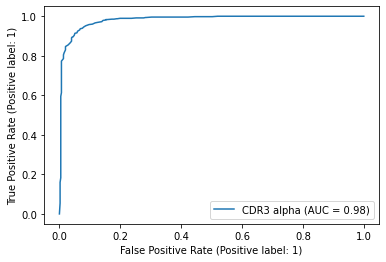

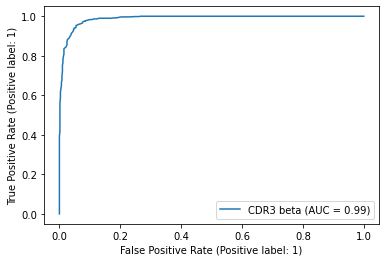

In [8]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test_a, clf_alpha.predict_proba(X_test_a)[:,1], name='CDR3 alpha')
RocCurveDisplay.from_predictions(y_test_b, clf_beta.predict_proba(X_test_b)[:,1], name='CDR3 beta')
plt.show()

Precision recall

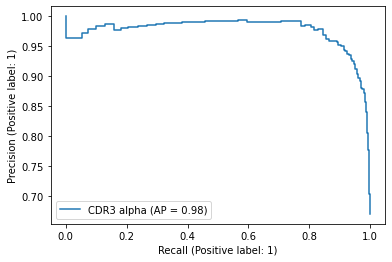

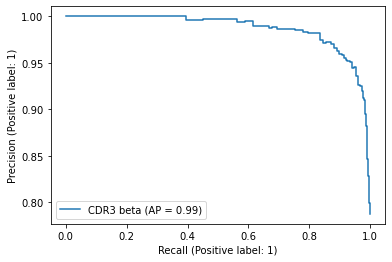

In [9]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test_a, clf_alpha.predict_proba(X_test_a)[:,1], name='CDR3 alpha')
PrecisionRecallDisplay.from_predictions(y_test_b, clf_beta.predict_proba(X_test_b)[:,1], name='CDR3 beta')
plt.show()

### Repeat experiments with randomly shuffled labels
AUC plots

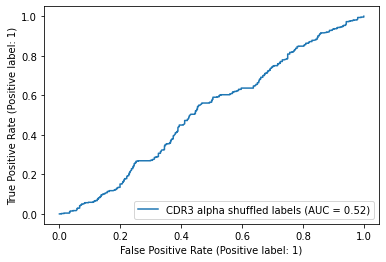

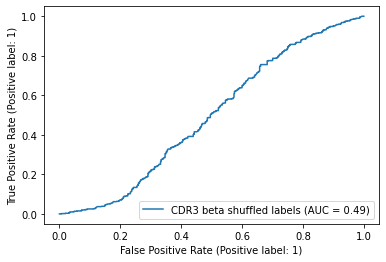

In [10]:
from numpy import random

random.shuffle(y_train_a)
random.shuffle(y_train_b)
clf_alpha_sfl = RandomForestClassifier().fit(X_train_a, y_train_a)
clf_beta_sfl = RandomForestClassifier().fit(X_train_b, y_train_b)

RocCurveDisplay.from_predictions(y_test_a, clf_alpha_sfl.predict_proba(X_test_a)[:,1], name='CDR3 alpha shuffled labels')
RocCurveDisplay.from_predictions(y_test_b, clf_beta_sfl.predict_proba(X_test_b)[:,1], name='CDR3 beta shuffled labels')
plt.show()